In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from IPython.display import display, HTML
from numpy.fft import fft2, ifft2 
from matlab.engine import *
display(HTML("<style>.container { width:70% !important; }</style>"))

In [3]:
def my_plot_im(image, ax = None):
    if ax is None:
        plt.figure(figsize=(10,10))
        if image.ndim ==2:
            plt.imshow(image, cmap='gray')
        else:
            plt.imshow(image)
        plt.axis('off')
        plt.show()
    else:
        for idx,img in enumerate(image):
            if img.ndim ==2:
                ax[idx].imshow(img, cmap='gray')
            else:
                ax[idx].imshow(img)
            ax[idx].axis('off')
        plt.show()
            

In [4]:
image = cv2.imread('./inputflower.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

my_plot_im(image)

#### Gaussian for removing high-frequency noise

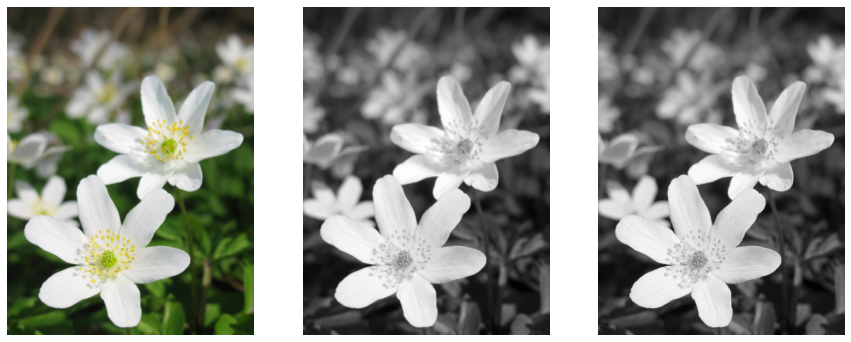

In [5]:
blurred_image = cv2.GaussianBlur(image, (3,3), 3, cv2.BORDER_REFLECT)
grayed_blurred = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2GRAY)
grayed = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

_, ax = plt.subplots(1,3,figsize=(15,10))
my_plot_im([blurred_image, grayed_blurred, grayed], ax=ax)

#### Simpler spectrum contrast (not local)

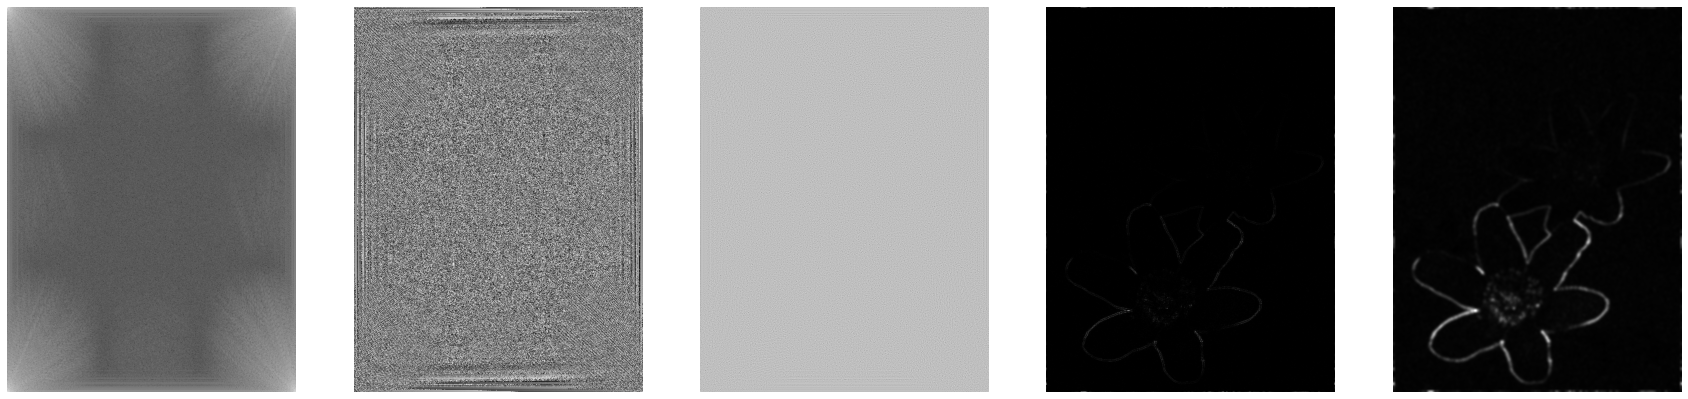

In [64]:
image_fft = fft2(grayed_blurred)

'''Log amplitude'''
log_amplitude = np.log(np.abs(image_fft))
phase_fft = np.angle(image_fft)

spectral_contrast = log_amplitude - cv2.blur(log_amplitude, (3,3), cv2.BORDER_REPLICATE)
sparse_depth = np.abs(ifft2(np.exp(spectral_contrast + 1j * phase_fft))) ** 2

sparse_contrast = cv2.GaussianBlur(sparse_depth, [11,11],2.5) # Why (10,10)???
_, ax = plt.subplots(1,5,figsize=(30,10))
my_plot_im([log_amplitude, phase_fft, spectral_contrast, sparse_depth, sparse_contrast,], ax=ax)

In [63]:
sparse_depth.max(), sparse_contrast.max()

(0.0008514954915957577, 0.00012635772323405797)

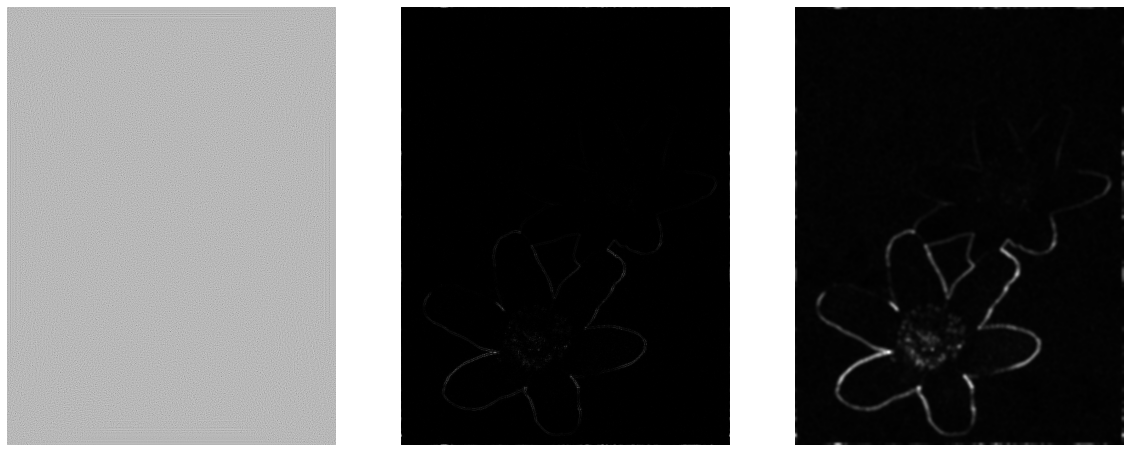

In [7]:
'''Actual last 3 images.'''
c=cv2.imread('SparseContrast.png',0)
b=cv2.imread('./SparseDepth.png',0)
a=cv2.imread('./SpectralContrast.png',0)

# print(c)
_, ax = plt.subplots(1,3,figsize=(20,10))
my_plot_im([a,b,c], ax=ax)

#### Supress color Abbreation

In [15]:
canny_img = np.zeros_like(image)
other_canny = np.zeros_like(image[:,:,:])
edges = np.zeros_like(image[:,:,0])
edges1 = np.zeros_like(image[:,:,0])

'''Unfortuanetely, canny detection is different in Matlab and OpenCV. We need to find good parameters.'''
for i in range(3):
    canny_img[:,:,i]=cv2.GaussianBlur(image[:,:,i], (15,15),np.sqrt(2))
    canny_img[:,:,i]= cv2.Canny(canny_img[:,:,i], 0.0, 27)
    other_canny[:,:,i] = cv2.Canny(image[:,:,i], 0, 90)

x= np.sum(canny_img,axis=-1) >=2 *255
edges[np.asarray(x)] = 1

x= np.sum(other_canny,axis=-1) >=2 *255
edges1[np.asarray(x)] = 1
_, ax = plt.subplots(1,4,figsize=(30,10))
my_plot_im([canny_img, canny_img[:,:,0],edges,edges1], ax=ax)

img = cv2.imread('./original_edge.png',0)
_, ax = plt.subplots(1,2,figsize=(20,10))
my_plot_im([edges,img],ax=ax)

In [196]:
c.max(),img.max(),edges.max(),sparse_contrast.max(),sparse_contrast.min()

(255, 255, 1, 0.00012635772323405797, 2.77619349133371e-07)

#### IP function - 

In [208]:
eng = start_matlab()
D = eng.GetSparseDfocusFromcontrastData(image.shape[0],image.shape[1],sparse_contrast/sparse_contrast.max(), edges)
print(np.asarray(D))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [237]:
numpyD = np.array(D)
# numpyD[numpyD != 0], 
Z = np.isclose(numpyD[numpyD !=0 ], 0,rtol=0.0003) 
Z.shape,numpyD[numpyD !=0 ][np.logical_not(Z)]

# '''All not zero terms are close to -1j'''

((21332,),
 array([0.10240948, 0.10680122, 0.11693743, ..., 0.04966351, 0.06414504,
        0.05235407]))

In [249]:
numpyD[np.isinf(numpyD)] = 1
numpyD[numpyD !=0].min(),numpyD.max()

(0.004551803775703986, 0.7682878803405225)

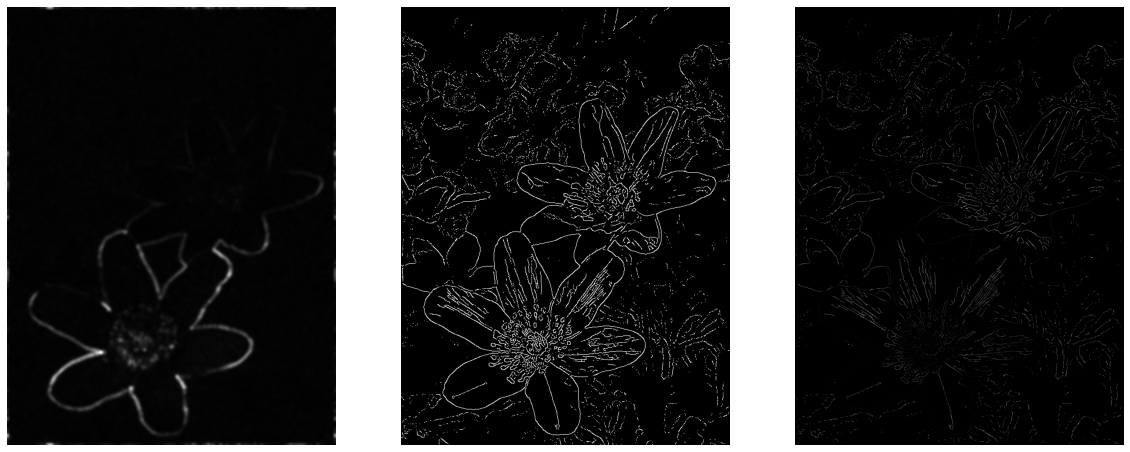

In [250]:
'''From SparseContrast Edges -> numpyD'''
# numpyD = (np.asarray(D)).real
_, ax = plt.subplots(1,3,figsize=(20,10))
my_plot_im([sparse_contrast, edges, numpyD], ax=ax)

In [251]:
'''Comparision between Actual D and if we scale it appropriately. I decided to scale since it looked like 
the function returns imaginary values close to -1j. Idk why the image has random pixel values at that positions.'''
actual_D=cv2.imread('./D.png',0)
_, ax = plt.subplots(1,2,figsize=(20,10))
my_plot_im([actual_D, actual_D/(actual_D+1e-6)], ax=ax)

In [252]:
numpyD.max(),edges.max()

(0.7682878803405225, 1)

In [253]:
'''Looks like IP function does not do anything special in Python. But matlab results look weird'''
actual_D_upd = actual_D / (actual_D +1e-5)
np.abs(numpyD - edges).sum()/img.size, np.abs(actual_D_upd-numpyD).sum()/img.size, np.abs(actual_D_upd-img).sum()/img.size

(0.03607040946138639, 0.046595077814400435, 12.258675023424507)

In [254]:
temp = numpyD/numpyD.max()*255
(numpyD-actual_D/255).sum()/temp[temp!=0].size

-0.06132113368734348

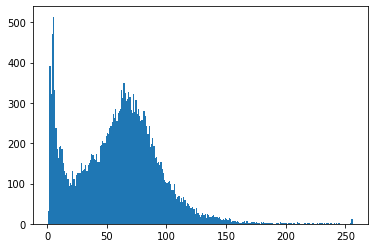

In [255]:
# a,b=np.histogram(actual_D.flatten(),bins=255)
plt.hist(actual_D.flatten(),255,[1,256])
plt.show()

In [256]:
plt.hist(temp.flatten(),255,[1,256])
plt.show()

In [257]:
_, ax = plt.subplots(1,2,figsize=(20,15))
my_plot_im([numpyD, actual_D], ax=ax)

#### Bilateral filter: 

In [258]:
numpyD.max(), actual_D.max()

(0.7682878803405225, 255)

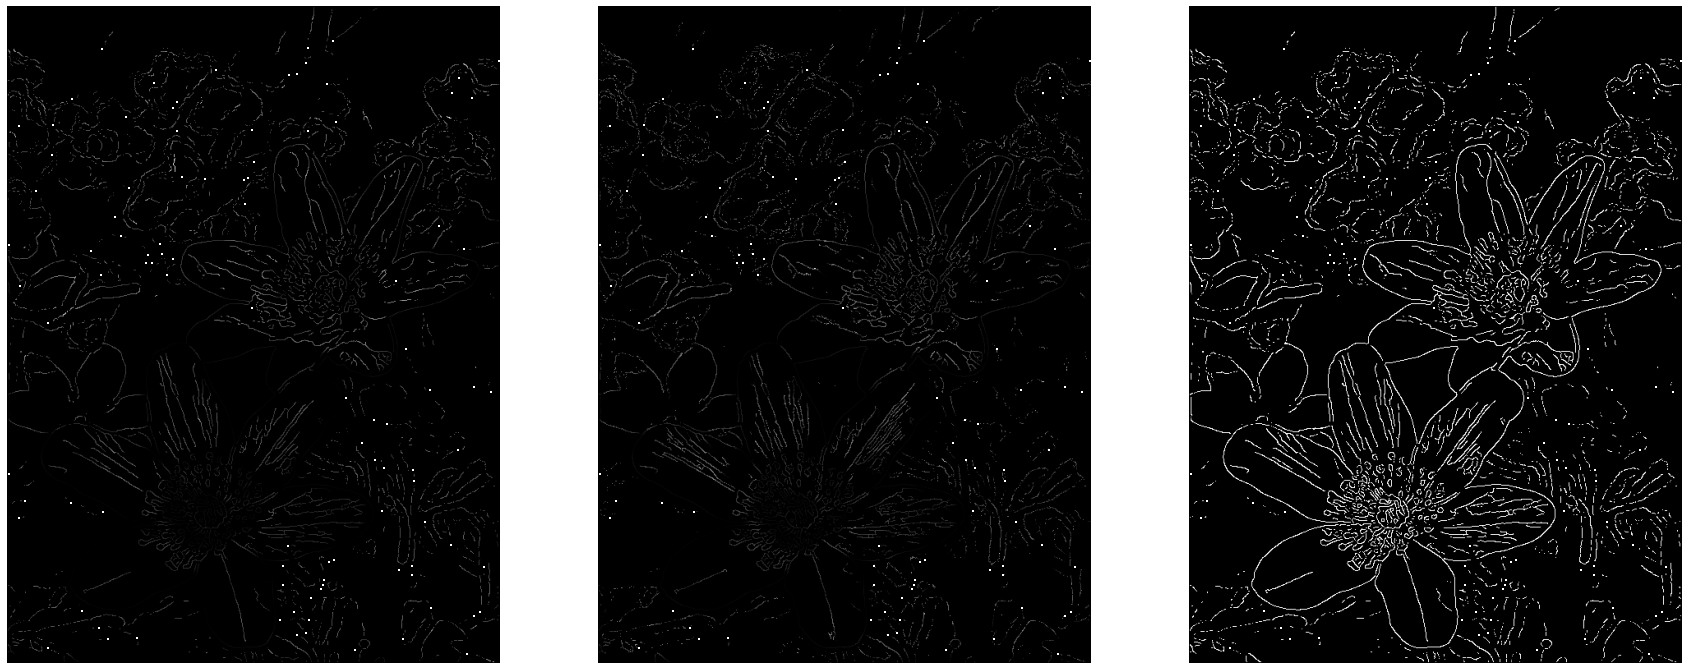

In [259]:
'''Using numpyD since there is little difference'''

'''Using their bilateral function on their image, (t->their, o->our, x->other)''' 
afterBilateral_tt = np.array(eng.BilateralFilter(actual_D/255,image/255))
afterBilateral_to = np.array(eng.BilateralFilter(np.ascontiguousarray(numpyD),image/255))
afterBilateral_tx = np.array(eng.BilateralFilter(actual_D_upd,image))

_, ax = plt.subplots(1,3,figsize=(30,20))
my_plot_im([afterBilateral_tt, afterBilateral_to, afterBilateral_tx], ax=ax)

In [260]:
'''there are  NaN, here.'''
print(np.isnan(afterBilateral_tt).sum())
print(np.isnan(afterBilateral_to).sum())
print(np.isnan(afterBilateral_tx).sum())

afterBilateral_tt[np.isnan(afterBilateral_tt)]=0
afterBilateral_to[np.isnan(afterBilateral_to)]=0
afterBilateral_tx[np.isnan(afterBilateral_tx)]=0

100
100
100


In [264]:
afterBilateral_to.max()

0.6753631227286678

In [265]:
np.abs(afterBilateral_tt-afterBilateral_to).sum()/afterBilateral_to[afterBilateral_to!=0].size,np.abs(afterBilateral_to).sum()

(0.1579897015055551, 3916.517342991435)

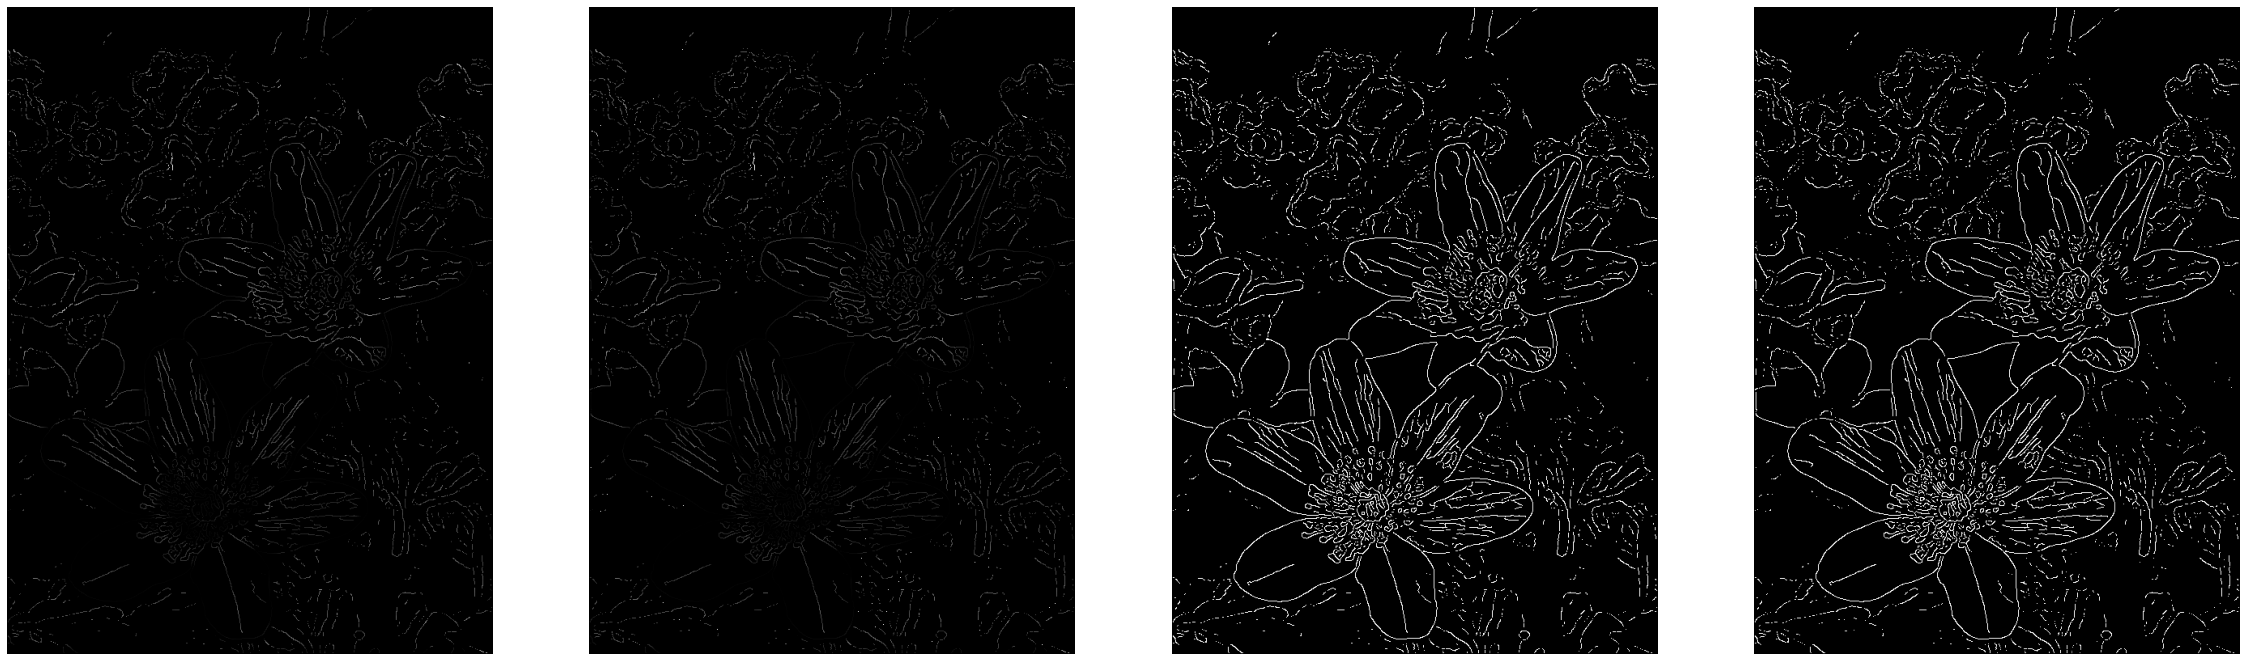

In [271]:
afterBilateral_actual = cv2.imread('./afterBilateral.png',0)

thresh_a, thresh_b = afterBilateral_tt / (afterBilateral_tt+1e-6), afterBilateral_actual/(afterBilateral_actual+1e-6)
_, ax = plt.subplots(1,4,figsize=(40,30))
my_plot_im([afterBilateral_tt, afterBilateral_actual, thresh_a, thresh_b], ax=ax)

In [274]:
np.abs(afterBilateral_tt-afterBilateral_actual/255).sum()/afterBilateral_actual[afterBilateral_actual!=0].size

0.013715478399892136

In [276]:
'''Difference in running their function on their input vs their output'''
print(np.abs(afterBilateral_tt - afterBilateral_actual/255).sum()/img.size)

'''Output vs input'''
print(np.abs(afterBilateral_tt - actual_D).sum()/img.size)

0.0006619432762747942
2.818653117469504


In [ ]:
'''Aplying bilateral filter ourselves'''

